In [21]:
%matplotlib inline
import random
from mxnet import autograd, gluon, init, np, npx
from d2l import mxnet as d2l
from mxnet.gluon import nn

npx.set_np()

# Exercises week 4
## 5.1.6.2

In [24]:
class Parallel(nn.Block):
    def __init__(self, a, b, **kwargs):
        super(Parallel, self).__init__(**kwargs)
        self.net1 = a
        self.net2 = b

    def forward(self, x):
        out1 = self.net1(x)
        out2 = self.net2(x)
        print(out1.shape)
        print(out2.shape)
        return out2

x = np.random.uniform(size=(2, 20))
net1 = nn.Sequential()
net1.add(nn.Dense(64, activation='relu'), nn. Dense(32, activation='relu'))
net2 = nn.Sequential()
net2.add(nn.Dense(64, activation='relu'))
parallel = Parallel(net1, net2)
parallel.initialize()
parallel(x)

(2, 32)
(2, 64)


array([[-0.        ,  0.15247235,  0.07538312,  0.15838312, -0.        ,
         0.07617746, -0.        , -0.        , -0.        , -0.        ,
         0.18074597,  0.09989716, -0.        , -0.        , -0.        ,
         0.00444147, -0.        , -0.        , -0.        ,  0.03703511,
         0.04957684, -0.        , -0.        , -0.        ,  0.12827879,
        -0.        , -0.        ,  0.07501735,  0.05321858, -0.        ,
         0.06208777,  0.10418778,  0.07398394,  0.04528458,  0.06440263,
        -0.        ,  0.01423512,  0.01561122, -0.        , -0.        ,
         0.08651073,  0.09335428,  0.05919142,  0.08120992,  0.05764378,
        -0.        , -0.        ,  0.06515741, -0.        , -0.        ,
         0.14760105,  0.11609581,  0.07861418,  0.02089214, -0.        ,
         0.03735511, -0.        ,  0.07760446,  0.1731125 , -0.        ,
         0.09576292,  0.20592007, -0.        ,  0.11187842],
       [-0.        ,  0.22868979,  0.11147101,  0.12673485,  0.

## 5.2.5.4

By sharing parameters (weights, bias), we ensure that the same weights are used on all of the input, even if those parts are processed by different blocks.


In [17]:
net = nn.Sequential()
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.Dense(8, activation='relu')
net.add(nn.Dense(8, activation='relu'), shared,
        nn.Dense(8, activation='relu', params=shared.params), nn.Dense(10))
net.initialize()

X = np.random.uniform(size=(2, 20))
net(X)

# Check whether the parameters are the same
print(net[1].weight.data()[0])
net[1].weight.data()[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[1].weight.data()[0] == net[2].weight.data()[0])

[ 0.03442463  0.01942655 -0.0591896  -0.00175511 -0.04656868 -0.0456658
  0.05133796 -0.01061028]
[ True  True  True  True  True  True  True  True]


## 5.3.3.1


In [19]:
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(256, activation='relu', in_units=20))
    net.add(nn.Dense(10))
    return net

net = get_net()
net.initialize()
net.collect_params()

sequential2_ (
  Parameter dense29_weight (shape=(256, 20), dtype=float32)
  Parameter dense29_bias (shape=(256,), dtype=float32)
  Parameter dense30_weight (shape=(10, -1), dtype=float32)
  Parameter dense30_bias (shape=(10,), dtype=float32)
)

As can be seen, if we specify the input dimension of one layer, only the weights for this layer are initalised. The other layer is still not initalised.

## 6.1.6.1  

If we simply fill out $\Delta = 0$, we get $[H]_{i,j,d} = \sum_{a=0}^0 \sum_{b=0}^0 \sum_c [V]_{0,0,c,d} [X]_{i,j,c}$. <br>
If we omit the first two summations, we get $\sum_c [V]_{0,0,c,d} [X]_{i,j,c}$. This is equivalent to running a separate MLP for each channel, and then summing the values together (which is what we would have done anyway in the output layer).

## 6.3.4.2


In [25]:
# For convenience, we define a function to calculate the convolutional layer.
# This function initializes the convolutional layer weights and performs
# corresponding dimensionality elevations and reductions on the input and
# output
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # Here (1, 1) indicates that the batch size and the number of channels
    # are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions that do not interest us: examples and
    # channels
    return Y.reshape(Y.shape[2:])

# Some experiments with different values
conv2d = nn.Conv2D(1, kernel_size=3, padding=1)
X = np.random.uniform(size=(8, 8))
print(comp_conv2d(conv2d, X).shape)

conv2d = nn.Conv2D(1, kernel_size=(3, 5), padding=1, strides=1)
print(comp_conv2d(conv2d, X).shape)

conv2d = nn.Conv2D(1, kernel_size=(3, 5), padding=(0,1), strides=(1,1))
print(comp_conv2d(conv2d, X).shape)

conv2d = nn.Conv2D(1, kernel_size=(3, 5), padding=(2,2), strides=(3,5))
print(comp_conv2d(conv2d, X).shape)

(8, 8)
(8, 6)
(6, 6)
(4, 2)


## 6.4.5.1

Treat each 'loose' kernel as a channel. We can then concatenate these channels in the output, where we would get a shape of $2 \times 2 \times k_1 \times k_2$.


## 6.5.5.1

We can modify the cross-corelation operation to immediately pool the results using average pooling, as shown below.

In [30]:
def corr2davgpool(X, K):
    """Compute 2D cross-correlation with average pooling"""
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + p_h, j:j + p_w] * K).mean()
    return Y

def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

class Conv2D(nn.Block):
    def __init__(self, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.weight = self.params.get('weight', shape=kernel_size)
        self.bias = self.params.get('bias', shape=(1,))

    def forward(self, x):
        return corr2davgpool(x, self.weight.data()) + self.bias.data()

batch 2, loss 0.958
batch 4, loss 255.164
batch 6, loss 67974.336
batch 8, loss 18107996.000
batch 10, loss 4823871488.000


## 6.6.4.1

loss 0.413, train acc 0.846, test acc 0.828
8357.3 examples/sec on gpu(0)


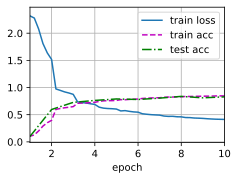

In [33]:
net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    nn.MaxPool2D(pool_size=2, strides=2),
    # `Dense` will transform an input of the shape (batch size, number of
    # channels, height, width) into an input of the shape (batch size,
    # number of channels * height * width) automatically by default
    nn.Dense(120, activation='sigmoid'), nn.Dense(84, activation='sigmoid'),
    nn.Dense(10))

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if not device:  # Query the first device where the first parameter is on
        device = list(net.collect_params().values())[0].list_ctx()[0]
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the major difference from `d2l.train_epoch_ch3`
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.482, train acc 0.816, test acc 0.824
14065.6 examples/sec on gpu(0)


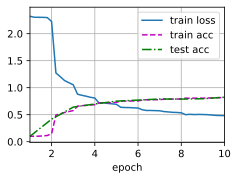

In [34]:
net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides=2),
    # `Dense` will transform an input of the shape (batch size, number of
    # channels, height, width) into an input of the shape (batch size,
    # number of channels * height * width) automatically by default
    nn.Dense(120, activation='sigmoid'), nn.Dense(84, activation='sigmoid'),
    nn.Dense(10))

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

It seems that performance with Max pooling is slightly better, but that average pooling is slightly faster. This makes sense, as it is known that max pooling works better. In the end, perhaps also because this example is rather simple, the performance is quite close.

## 7.5.5.1

loss 0.249, train acc 0.909, test acc 0.784
10930.6 examples/sec on gpu(0)


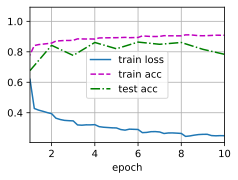

In [35]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5), nn.BatchNorm(), nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(), nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Dense(120), nn.BatchNorm(),
        nn.Activation('sigmoid'), nn.Dense(84), nn.BatchNorm(),
        nn.Activation('sigmoid'), nn.Dense(10))

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.335, train acc 0.877, test acc 0.850
19974.8 examples/sec on gpu(0)


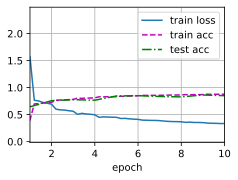

In [36]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5), nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Conv2D(16, kernel_size=5),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Dense(120),
        nn.Activation('sigmoid'), nn.Dense(84),
        nn.Activation('sigmoid'), nn.Dense(10))

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Accuracy is much higher when using batch normalisation.


## 7.6.6.1

The Inception Block is parallel, whereas the ResNet block is not. If we remove the parllelism from the Inception block, we would get a block that is very similar to the ResNet block. The only difference then is that the residual connector is passed on twice. We would remove on of these, and then remove the 1x1 convolutional block. The resulting block is almost identical to the ResNet block.